In [3]:
!pip install ipython-autotime
%load_ext autotime
!pip install transformers
!pip install -U accelerate
!pip install -U datasets
!pip install seqeval
!pip install evaluate
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=96a7392c31eeaeefd68f23035d28aebc4daaac6d161b6373dc8c2b26e5653f8b
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.5 MB/s eta 0:00:00
time: 35.2 s (started: 2023-

In [4]:
import os

# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

time: 511 µs (started: 2023-12-16 16:06:16 +00:00)


In [5]:
import pandas as pd
import torch
import numpy as np
import re
import json
import copy
import random
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from transformers import Trainer, T5Tokenizer, AdamW, T5ForConditionalGeneration, TrainingArguments, EvalPrediction, AutoTokenizer
from datasets import Dataset, DatasetDict, ClassLabel

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

lb = LabelBinarizer()
mlb = MultiLabelBinarizer()

time: 9.65 s (started: 2023-12-16 16:06:16 +00:00)


In [6]:
model_name = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = T5ForConditionalGeneration.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

time: 25.7 s (started: 2023-12-16 16:06:26 +00:00)


In [7]:
print(tokenizer.is_fast)

True
time: 426 µs (started: 2023-12-16 16:06:51 +00:00)


In [8]:
"""
 ['How', [PTAG], 'NN', [TTAG], 'O', 'many', 'heads', 'of', 'the', 'departments', 'are', 'older', 'than', '56', '?', '[SEP]', '[T]', 'department', '[C]', 'department id', '[C]', 'name', '[C]', 'creation', '[C]', 'ranking', '[C]', 'budget in billions', '[C]', 'num employees', '[T]', 'head', '[C]', 'head id', '[C]', 'name', '[C]', 'born state', '[C]', 'age', '[T]', 'management', '[C]', 'department id', '[C]', 'head id', '[C]', 'temporary acting']
"""

"\n ['How', [PTAG], 'NN', [TTAG], 'O', 'many', 'heads', 'of', 'the', 'departments', 'are', 'older', 'than', '56', '?', '[SEP]', '[T]', 'department', '[C]', 'department id', '[C]', 'name', '[C]', 'creation', '[C]', 'ranking', '[C]', 'budget in billions', '[C]', 'num employees', '[T]', 'head', '[C]', 'head id', '[C]', 'name', '[C]', 'born state', '[C]', 'age', '[T]', 'management', '[C]', 'department id', '[C]', 'head id', '[C]', 'temporary acting']\n"

time: 1.87 ms (started: 2023-12-16 16:06:51 +00:00)


**Adding Special Tokens**
We are using T5 model, so we need to add our newly introducez tokens to model's vocabulary. Also, since T5 model does not use SEP, we need to add it as well.

In [9]:
# Add a new special token
num_added_special_tokend = tokenizer.add_special_tokens({'additional_special_tokens': ['[TTAG]', '[POS]', '[WORDSEP]', '[STAG]', '[SEP]', '[T]', '[C]']})
print(num_added_special_tokend)

# Resize the token embeddings in the model
model.resize_token_embeddings(len(tokenizer))

# Verify the updated special tokens
print("Updated Special Tokens:")
special_tokens = tokenizer.convert_ids_to_tokens(tokenizer.all_special_ids)
print(special_tokens)


7
Updated Special Tokens:
['</s>', '<unk>', '<pad>', '[T]', '[C]', '[STAG]', '[POS]', '[WORDSEP]', '[TTAG]', '[SEP]']
time: 222 ms (started: 2023-12-16 16:06:51 +00:00)


In [10]:
from google.colab import drive
drive.mount('/content/drive')
dbtagger_dataset_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/'
imdbTrainDbTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/imdbTrainDbTag.txt'
imdbTestDbTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/imdbTestDbTag.txt'
scholarTrainDbTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/scholarTrainDbTag.txt'
scholarTestDbTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/scholarTestDbTag.txt'
yelpTrainDBTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/yelpTrainDbTag.txt'
yelpTestDBTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/yelpTestDbTag.txt'
spider_tables_json = '/content/drive/MyDrive/CS559_shared/implementation/spider/tables.json'

Mounted at /content/drive
time: 25 s (started: 2023-12-16 16:06:52 +00:00)


In [11]:
# Extracting spider database table
spider_table_json_file = open(spider_tables_json)
spider_table_info_list = json.load(spider_table_json_file)
# print(spider_table_info_list)
spider_table_info_dict={}
# print(spider_table_info_list[0]['db_id'])

# storing as a dict
for db_dict in spider_table_info_list:
  if db_dict['db_id'] not in spider_table_info_dict:
    spider_table_info_dict[db_dict['db_id']] = db_dict

print(spider_table_info_dict)


{'perpetrator': {'column_names': [[-1, '*'], [0, 'perpetrator id'], [0, 'people id'], [0, 'date'], [0, 'year'], [0, 'location'], [0, 'country'], [0, 'killed'], [0, 'injured'], [1, 'people id'], [1, 'name'], [1, 'height'], [1, 'weight'], [1, 'home town']], 'column_names_original': [[-1, '*'], [0, 'Perpetrator_ID'], [0, 'People_ID'], [0, 'Date'], [0, 'Year'], [0, 'Location'], [0, 'Country'], [0, 'Killed'], [0, 'Injured'], [1, 'People_ID'], [1, 'Name'], [1, 'Height'], [1, 'Weight'], [1, 'Home Town']], 'column_types': ['text', 'number', 'number', 'text', 'number', 'text', 'text', 'number', 'number', 'number', 'text', 'number', 'number', 'text'], 'db_id': 'perpetrator', 'foreign_keys': [[2, 9]], 'primary_keys': [1, 9], 'table_names': ['perpetrator', 'people'], 'table_names_original': ['perpetrator', 'people']}, 'college_2': {'column_names': [[-1, '*'], [0, 'building'], [0, 'room number'], [0, 'capacity'], [1, 'department name'], [1, 'building'], [1, 'budget'], [2, 'course id'], [2, 'title']

In [12]:
def get_db_tables_and_columns(spider_table_info_dict, db_id):
  db_table_columns_dict = {}
  table_names = spider_table_info_dict[db_id]['table_names_original']
  for table_index in range(len(table_names)):
    table_name = table_names[table_index]
    db_table_columns_dict[table_name] = [col_item[1] for col_item in spider_table_info_dict[db_id]['column_names_original'] if col_item[0] == table_index ]

  return db_table_columns_dict

time: 506 µs (started: 2023-12-16 16:07:21 +00:00)


In [13]:
# examining the get_db_tables_and_columns function
# let say I want to get the tables and their columns in yelp db, imdb db and scholar db
yelp_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'yelp')
imdb_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'imdb')
scholar_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'scholar')

academic_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'academic')
college_1_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'college_1')
hr_1_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'hr_1')

print('yelp db tables and columns: \n', yelp_tables_columns)
print('imdb db tables and columns: \n', imdb_tables_columns)
print('scholar db tables and columns: \n', scholar_tables_columns)
print('academic db tables and columns: \n', academic_tables_columns)
print('college_1 db tables and columns: \n', college_1_tables_columns)
print('hr_1 db tables and columns: \n', hr_1_tables_columns)

yelp db tables and columns: 
 {'business': ['bid', 'business_id', 'name', 'full_address', 'city', 'latitude', 'longitude', 'review_count', 'is_open', 'rating', 'state'], 'category': ['id', 'business_id', 'category_name'], 'user': ['uid', 'user_id', 'name'], 'checkin': ['cid', 'business_id', 'count', 'day'], 'neighbourhood': ['id', 'business_id', 'neighbourhood_name'], 'review': ['rid', 'business_id', 'user_id', 'rating', 'text', 'year', 'month'], 'tip': ['tip_id', 'business_id', 'text', 'user_id', 'likes', 'year', 'month']}
imdb db tables and columns: 
 {'actor': ['aid', 'gender', 'name', 'nationality', 'birth_city', 'birth_year'], 'copyright': ['id', 'msid', 'cid'], 'cast': ['id', 'msid', 'aid', 'role'], 'genre': ['gid', 'genre'], 'classification': ['id', 'msid', 'gid'], 'company': ['id', 'name', 'country_code'], 'director': ['did', 'gender', 'name', 'nationality', 'birth_city', 'birth_year'], 'producer': ['pid', 'gender', 'name', 'nationality', 'birth_city', 'birth_year'], 'directed_

In [14]:
def retrieve_data_and_tag(path):
    file = open(path, 'r')
    sentences, sentence_tags = [], []
    for line in file:
        # line = re.sub(r"\".*\"","\"xxx\"",line)
        line = re.sub(r"'", "", line)
        word_tag_list = line.split()
        words = []
        tags = []
        for w in word_tag_list:
            item = w.split('/')
            if (len(item[0]) == 0):
                continue

            words.append(item[0])
            if (len(item) < 2):
                print(path, item)
            tags.append(item[1])
        sentences.append(words)
        sentence_tags.append(tags)
        if (len(sentences) != len(sentence_tags)):
            print(line)
    return sentences, sentence_tags

time: 566 µs (started: 2023-12-16 16:07:21 +00:00)


In [15]:

def split_train_test(question_list, type_tags_list, db_tags_list, pos_tags_list, train_percentage=0.9):
    # Check if the input lists have the same length
    if len(question_list) != len(type_tags_list) or len(question_list) != len(db_tags_list) or len(question_list) != len(pos_tags_list):
        raise ValueError("Input lists must have the same length")

    # Calculate the number of elements for the training set
    num_train_elements = int(len(question_list) * train_percentage)

    # Generate random indexes for the training set
    train_indexes = random.sample(range(len(question_list)), num_train_elements)

    # Create training and test sets for each list
    train_questions = [question_list[i] for i in train_indexes]
    test_questions = [question_list[i] for i in range(len(question_list)) if i not in train_indexes]

    train_type_tags = [type_tags_list[i] for i in train_indexes]
    test_type_tags = [type_tags_list[i] for i in range(len(type_tags_list)) if i not in train_indexes]

    train_db_tags = [db_tags_list[i] for i in train_indexes]
    test_db_tags = [db_tags_list[i] for i in range(len(db_tags_list)) if i not in train_indexes]

    train_pos_tags = [pos_tags_list[i] for i in train_indexes]
    test_pos_tags = [pos_tags_list[i] for i in range(len(pos_tags_list)) if i not in train_indexes]

    return (
        train_questions, test_questions,
        train_type_tags, test_type_tags,
        train_db_tags, test_db_tags,
        train_pos_tags, test_pos_tags
    )


time: 835 µs (started: 2023-12-16 16:07:21 +00:00)


# We firsly need to get Type Tags and Schema Tags of our databases. Since these databases are already splitted into Train and Test by Arif Usta, there is no need for further process.


In [16]:

# db_id = imdb
imdb_train_questions, imdb_train_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/imdbTrainTag.txt")
imdb_train_questions, imdb_train_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/imdbTrainDbTag.txt")
imdb_train_questions, imdb_train_pos_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/imdbTrainPos.txt")

imdb_test_questions, imdb_test_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/imdbTestTag.txt")
imdb_test_questions, imdb_test_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/imdbTestDbTag.txt")
imdb_test_questions, imdb_test_pos_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/imdbTestPos.txt")

# db_id = scholar
scholar_train_questions, scholar_train_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/scholarTrainTag.txt")
scholar_train_questions, scholar_train_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/scholarTrainDbTag.txt")
scholar_train_questions, scholar_train_pos_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/scholarTrainPos.txt")

scholar_test_questions, scholar_test_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/scholarTestTag.txt")
scholar_test_questions, scholar_test_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/scholarTestDbTag.txt")
scholar_test_questions, scholar_test_pos_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/scholarTestPos.txt")

# db_id = yelp
yelp_train_questions, yelp_train_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/yelpTrainTag.txt")
yelp_train_questions, yelp_train_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/yelpTrainDbTag.txt")
yelp_train_questions, yelp_train_pos_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/yelpTrainPos.txt")

yelp_test_questions, yelp_test_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/yelpTestTag.txt")
yelp_test_questions, yelp_test_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/yelpTestDbTag.txt")
yelp_test_questions, yelp_test_pos_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/yelpTestPos.txt")

time: 14.5 s (started: 2023-12-16 16:07:21 +00:00)


# Secondly, we need to get POS Tags, Type Tags and Schema Tags of our additional databases. However, these databases are not splitted into Train & Test datasets so we need to do this. While splitting them as Train & Test, all tags, (POS, Type and Schema) should be processed.


In [17]:
# db_id = academic
academic_questions, academic_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/academic/questionsTypeTag2.txt")
academic_questions, academic_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/academic/questionsDbTag2.txt")
academic_questions, academic_pos_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/academic/questionsPOS.txt")
academic_train_questions, academic_test_questions, academic_train_type_tags, academic_test_type_tags, academic_train_db_tags, academic_test_db_tags, academic_train_pos_tags, academic_test_pos_tags = split_train_test(academic_questions, academic_type_tags, academic_db_tags, academic_pos_tags)

# db_id = college_1
college_1_questions, college_1_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/college_1/questionsTypeTag2.txt")
college_1_questions, college_1_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/college_1/questionsDbTag2.txt")
college_1_questions, college_1_pos_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/college_1/questionsPOS.txt")
college_1_train_questions, college_1_test_questions, college_1_train_type_tags, college_1_test_type_tags, college_1_train_db_tags, college_1_test_db_tags, college_1_train_pos_tags, college_1_test_pos_tags = split_train_test(college_1_questions, college_1_type_tags, college_1_db_tags, college_1_pos_tags)

# db_id = hr_1
hr_1_questions, hr_1_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/hr_1/questionsTypeTag2.txt")
hr_1_questions, hr_1_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/hr_1/questionsDbTag2.txt")
hr_1_questions, hr_1_pos_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/hr_1/questionsPOS.txt")
hr_1_train_questions, hr_1_test_questions, hr_1_train_type_tags, hr_1_test_type_tags, hr_1_train_db_tags, hr_1_test_db_tags, hr_1_train_pos_tags, hr_1_test_pos_tags = split_train_test(hr_1_questions, hr_1_type_tags, hr_1_db_tags, hr_1_pos_tags)

# db_id = imdb
imdb_2_questions, imdb_2_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/imdb_2/questionsTypeTag2.txt")
imdb_2_questions, imdb_2_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/imdb_2/questionsDbTag2.txt")
imdb_2_questions, imdb_2_pos_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/imdb_2/questionsPOS.txt")
imdb_2_train_questions, imdb_2_test_questions, imdb_2_train_type_tags, imdb_2_test_type_tags, imdb_2_train_db_tags, imdb_2_test_db_tags, imdb_2_train_pos_tags, imdb_2_test_pos_tags = split_train_test(imdb_2_questions, imdb_2_type_tags, imdb_2_db_tags, imdb_2_pos_tags)

# db_id = yelp
yelp_2_questions, yelp_2_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/yelp_2/questionsTypeTag2.txt")
yelp_2_questions, yelp_2_db_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/yelp_2/questionsDbTag2.txt")
yelp_2_questions, yelp_2_pos_tags = retrieve_data_and_tag(dbtagger_dataset_path + "Spider/yelp_2/questionsPOS.txt")
yelp_2_train_questions, yelp_2_test_questions, yelp_2_train_type_tags, yelp_2_test_type_tags, yelp_2_train_db_tags, yelp_2_test_db_tags, yelp_2_train_pos_tags, yelp_2_test_pos_tags = split_train_test(yelp_2_questions, yelp_2_type_tags, yelp_2_db_tags, yelp_2_pos_tags)


time: 13.5 s (started: 2023-12-16 16:07:35 +00:00)


In [18]:
print(f"Academic DB Train Len: {len(academic_train_questions)}")
print(f"Academic DB Test Len: {len(academic_test_questions)}")

print(f"College 1 DB Train Len: {len(college_1_train_questions)}")
print(f"College 1 DB Test Len: {len(college_1_test_questions)}")

print(f"HR 1 DB Train Len: {len(hr_1_train_questions)}")
print(f"HR 1 DB Test Len: {len(hr_1_test_questions)}")

print(f"IMDB 2 DB Train Len: {len(imdb_2_train_questions)}")
print(f"IMDB 2 DB Test Len: {len(imdb_2_test_questions)}")

print(f"Yelp 2 DB Train Len: {len(yelp_2_train_questions)}")
print(f"Yelp 2 DB Test Len: {len(yelp_2_test_questions)}")

Academic DB Train Len: 162
Academic DB Test Len: 19
College 1 DB Train Len: 147
College 1 DB Test Len: 17
HR 1 DB Train Len: 111
HR 1 DB Test Len: 13
IMDB 2 DB Train Len: 98
IMDB 2 DB Test Len: 11
Yelp 2 DB Train Len: 99
Yelp 2 DB Test Len: 11
time: 1.12 ms (started: 2023-12-16 16:07:49 +00:00)


In [19]:
# Example with new additioinal special tokens [T] and [C]
print(imdb_train_questions[0])
print(imdb_train_type_tags[0])
print(imdb_train_pos_tags[0])
print(imdb_train_db_tags[0])
# The item at 3rd index in imdb_train_db_tags was wrongly hand anotated because there was COND Schema Tag which shouldn't be

example_serialized_query = []

example_query = imdb_train_questions[0]
example_query_pos_tags = imdb_train_pos_tags[0]
example_query_type_tags = imdb_train_type_tags[0]
example_query_db_tags = imdb_train_db_tags[0]
print('*'*30)

for idx, query_word in enumerate(example_query):
  if example_query_type_tags[idx] != 'O' and example_query_type_tags[idx] != 'COND':  # include only the words whose TTAG is not O
    example_serialized_query.append(query_word)
    # example_serialized_query.append("[PTAG]")
    # example_serialized_query.append(example_query_pos_tags[idx])
    example_serialized_query.append("[TTAG]")
    example_serialized_query.append(example_query_type_tags[idx])
    # example_serialized_query.append("[WORDSEP]")

example_serialized_query.append('[SEP]')
for key, value in imdb_tables_columns.items():
  example_serialized_query.append('[T]')
  example_serialized_query.append(key.replace(" ", "_"))
  # example_serialized_query.append('[C]')
  # for column in value:
  #   example_serialized_query.append(column)

print(example_serialized_query)
print('len: ', len(example_serialized_query))
print()
tokenized_text = tokenizer(example_serialized_query, padding='max_length', truncation=True, is_split_into_words=True )
print("Tokenized text: \n", tokenized_text)
print("Length of tokenized text: \n", len(tokenized_text['input_ids']))

['What', 'year', 'is', 'the', 'movie', 'Dead', 'Poets', 'Society', 'from', '?']
['O', 'ATTR', 'O', 'O', 'TABLE', 'VALUE', 'VALUE', 'VALUE', 'O', 'O']
['WDT', 'NN', 'VBZ', 'DT', 'NN', 'JJ', 'NNS', 'NN', 'IN', '.']
['O', 'movie.release_year', 'O', 'O', 'movie', 'movie.title', 'movie.title', 'movie.title', 'O', 'O']
******************************
['year', '[TTAG]', 'ATTR', 'movie', '[TTAG]', 'TABLE', 'Dead', '[TTAG]', 'VALUE', 'Poets', '[TTAG]', 'VALUE', 'Society', '[TTAG]', 'VALUE', '[SEP]', '[T]', 'actor', '[T]', 'copyright', '[T]', 'cast', '[T]', 'genre', '[T]', 'classification', '[T]', 'company', '[T]', 'director', '[T]', 'producer', '[T]', 'directed_by', '[T]', 'keyword', '[T]', 'made_by', '[T]', 'movie', '[T]', 'tags', '[T]', 'tv_series', '[T]', 'writer', '[T]', 'written_by']
len:  48

Tokenized text: 
 {'input_ids': [215, 32105, 8043, 11421, 1974, 32105, 332, 17098, 9651, 32105, 3, 21712, 5078, 1908, 15, 17, 7, 32105, 3, 21712, 5078, 3467, 32105, 3, 21712, 5078, 32106, 32100, 7556,

###Since this is a text to text language model, I have to rearrange the train_db_tags such that correct outputs can be **taken**

In [20]:

def serialize_input_output(query_input_list, query_type_tag_list, query_pos_tag_list, query_db_tag_list, db_tables_columns_dict):
  serialized_queries = []
  serialized_db_tags = []
  for query_tokens, token_type_tags, token_pos_tags, token_db_tags in zip(query_input_list, query_type_tag_list, query_pos_tag_list, query_db_tag_list):
    serialized_query = []
    serialized_db_tag = []

    # total_token_num = len(query_tokens)
    # initial_prefix = "generate exactly " + str(total_token_num) + " table names: "
    # initial_prefix_tokens = initial_prefix.split()
    # serialized_query = serialized_query + initial_prefix_tokens

    # for ind in range(len(initial_prefix_tokens)):
    #   serialized_db_tag.append('O')

    for idx, query_word in enumerate(query_tokens):
      serialized_query.append(query_word)

      db_tag = token_db_tags[idx]
      if '.' in db_tag:
        table_tag, att_tag = db_tag.split('.')
        serialized_db_tag.append(table_tag)
      else:
        if db_tag == 'COND':
          serialized_db_tag.append('O')
        else:
          serialized_db_tag.append(db_tag)

    serialized_query.append("[TTAG]")
    serialized_db_tag.append("O")
    # serialized_query = serialized_query + token_type_tags
    for ttag in token_type_tags:
      if ttag != 'O' and ttag != 'COND':
        serialized_query.append('TABLE')
        serialized_db_tag.append('O')
      else:
        serialized_query.append('O')
        serialized_db_tag.append('O')

    serialized_query.append('[POS]')
    serialized_db_tag.append("O")
    for ptag in token_pos_tags:
      serialized_query.append(ptag)
      serialized_db_tag.append("O")


    # serialized_query.append("[SEP]")
    serialized_query.append("[T]")
    serialized_db_tag.append("O")
    # serialized_db_tag.append('[SEP]')



    for key, value in db_tables_columns_dict.items():
      key = key.replace(" ", "_") # Remove spaces from table names

      # serialized_query.append("[T]")
      # serialized_db_tag.append('[T]')

      serialized_query.append(key)
      serialized_db_tag.append(key)

      # [C] tag is added 1 time for each table to shorten the input
      # serialized_query.append("[C]")
      # serialized_db_tag.append('[C]')


      # for column in value:
      #   column = column.replace(" ", "_") # Remove spaces from column names
      #   serialized_query.append(column)
      #   # serialized_db_tag.append(f"{key}.{column}")


    serialized_queries.append(serialized_query)
    serialized_db_tags.append(serialized_db_tag)


  return (serialized_queries, serialized_db_tags)


time: 755 µs (started: 2023-12-16 16:07:49 +00:00)


In [21]:
imdb_train_queries_serialized, imdb_train_db_tags_serialized = serialize_input_output(imdb_train_questions, imdb_train_type_tags, imdb_train_pos_tags, imdb_train_db_tags, imdb_tables_columns)
imdb_test_queries_serialized, imdb_test_db_tags_serialized = serialize_input_output(imdb_test_questions, imdb_test_type_tags, imdb_test_pos_tags, imdb_test_db_tags, imdb_tables_columns)
scholar_train_queries_serialized, scholar_train_db_tags_serialized = serialize_input_output(scholar_train_questions, scholar_train_type_tags, scholar_train_pos_tags, scholar_train_db_tags, scholar_tables_columns)
scholar_test_queries_serialized, scholar_test_db_tags_serialized =  serialize_input_output(scholar_test_questions, scholar_test_type_tags, scholar_test_pos_tags, scholar_test_db_tags, scholar_tables_columns)
yelp_train_queries_serialized, yelp_train_db_tags_serialized = serialize_input_output(yelp_train_questions, yelp_train_type_tags, yelp_train_pos_tags, yelp_train_db_tags, yelp_tables_columns)
yelp_test_queries_serialized, yelp_test_db_tags_serialized = serialize_input_output(yelp_test_questions, yelp_test_type_tags, yelp_test_pos_tags, yelp_test_db_tags, yelp_tables_columns)



# examining serialized queries
print('imdb_train_queries_serialized[0]: \n', imdb_train_queries_serialized[0])
print('Len imdb_train_queries_serialized[0]: ', len(imdb_train_queries_serialized[0]))
print('imdb_train_db_tags_serialized[0]: \n', imdb_train_db_tags_serialized[0])
print('Len imdb_train_db_tags_serialized[0]: ', len(imdb_train_db_tags_serialized[0]))
print()
print('scholar_train_queries_serialized[0]: \n', scholar_train_queries_serialized[0])
print('Len scholar_train_queries_serialized[0]: ', len(scholar_train_queries_serialized[0]))
print('scholar_train_db_tags_serialized[0]: \n', scholar_train_db_tags_serialized[0])
print('Len scholar_train_db_tags_serialized[0]: ', len(scholar_train_db_tags_serialized[0]))
print()
print('yelp_train_queries_serialized[0]: \n', yelp_train_queries_serialized[0])
print('Len yelp_train_queries_serialized[0]: ', len(yelp_train_queries_serialized[0]))
print('Len yelp_train_db_tags_serialized[0]: ', len(yelp_train_db_tags_serialized[0]))


imdb_train_queries_serialized[0]: 
 ['What', 'year', 'is', 'the', 'movie', 'Dead', 'Poets', 'Society', 'from', '?', '[TTAG]', 'O', 'TABLE', 'O', 'O', 'TABLE', 'TABLE', 'TABLE', 'TABLE', 'O', 'O', '[POS]', 'WDT', 'NN', 'VBZ', 'DT', 'NN', 'JJ', 'NNS', 'NN', 'IN', '.', '[T]', 'actor', 'copyright', 'cast', 'genre', 'classification', 'company', 'director', 'producer', 'directed_by', 'keyword', 'made_by', 'movie', 'tags', 'tv_series', 'writer', 'written_by']
Len imdb_train_queries_serialized[0]:  49
imdb_train_db_tags_serialized[0]: 
 ['O', 'movie', 'O', 'O', 'movie', 'movie', 'movie', 'movie', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'actor', 'copyright', 'cast', 'genre', 'classification', 'company', 'director', 'producer', 'directed_by', 'keyword', 'made_by', 'movie', 'tags', 'tv_series', 'writer', 'written_by']
Len imdb_train_db_tags_serialized[0]:  49

scholar_train_queries_serialized[0]: 
 ['How', 'many'

In [22]:
academic_train_queries_serialized, academic_train_db_tags_serialized = serialize_input_output(academic_train_questions, academic_train_type_tags, academic_train_pos_tags, academic_train_db_tags, academic_tables_columns)
academic_test_queries_serialized, academic_test_db_tags_serialized = serialize_input_output(academic_test_questions, academic_test_type_tags, academic_test_pos_tags, academic_test_db_tags, academic_tables_columns)
college_1_train_queries_serialized, college_1_train_db_tags_serialized = serialize_input_output(college_1_train_questions, college_1_train_type_tags, college_1_train_pos_tags, college_1_train_db_tags, college_1_tables_columns)
college_1_test_queries_serialized, college_1_test_db_tags_serialized =  serialize_input_output(college_1_test_questions, college_1_test_type_tags, college_1_test_pos_tags, college_1_test_db_tags, college_1_tables_columns)
hr_1_train_queries_serialized, hr_1_train_db_tags_serialized = serialize_input_output(hr_1_train_questions, hr_1_train_type_tags, hr_1_train_pos_tags, hr_1_train_db_tags, hr_1_tables_columns)
hr_1_test_queries_serialized, hr_1_test_db_tags_serialized = serialize_input_output(hr_1_test_questions, hr_1_test_type_tags, hr_1_test_pos_tags, hr_1_test_db_tags, hr_1_tables_columns)
imdb_2_train_queries_serialized, imdb_2_train_db_tags_serialized = serialize_input_output(imdb_2_train_questions, imdb_2_train_type_tags, imdb_2_train_pos_tags, imdb_2_train_db_tags, imdb_tables_columns)
imdb_2_test_queries_serialized, imdb_2_test_db_tags_serialized = serialize_input_output(imdb_2_test_questions, imdb_2_test_type_tags, imdb_2_test_pos_tags, imdb_2_test_db_tags, imdb_tables_columns)
yelp_2_train_queries_serialized, yelp_2_train_db_tags_serialized = serialize_input_output(yelp_2_train_questions, yelp_2_train_type_tags, yelp_2_train_pos_tags, yelp_2_train_db_tags, yelp_tables_columns)
yelp_2_test_queries_serialized,  yelp_2_test_db_tags_serialized = serialize_input_output(yelp_2_test_questions, yelp_2_test_type_tags, yelp_2_test_pos_tags, yelp_2_test_db_tags, yelp_tables_columns)

# examining serialized queries
print('academic_train_queries_serialized[0]: \n', academic_train_queries_serialized[0])
print('Len academic_train_queries_serialized[0]: ', len(academic_train_queries_serialized[0]))
print('academic_train_db_tags_serialized[0]: \n', academic_train_db_tags_serialized[0])
print('Len academic_train_db_tags_serialized[0]: ', len(academic_train_db_tags_serialized[0]))
print()
print('college_1_train_queries_serialized[0]: \n', college_1_train_queries_serialized[0])
print('college_1_train_db_tags_serialized[0]: \n', college_1_train_db_tags_serialized[0])
print()
print('hr_1_train_queries_serialized[0]: \n', hr_1_train_queries_serialized[0])
print('hr_1_train_db_tags_serialized[0]: \n', hr_1_train_db_tags_serialized[0])
print()
print('imdb_2_train_queries_serialized[0]: \n', imdb_2_train_queries_serialized[0])
print('imdb_2_train_db_tags_serialized[0]: \n', imdb_2_train_db_tags_serialized[0])
print()
print('yelp_2_train_queries_serialized[0]: \n', yelp_2_train_queries_serialized[0])
print('yelp_2_train_db_tags_serialized[0]: \n', yelp_2_train_db_tags_serialized[0])

academic_train_queries_serialized[0]: 
 ['return', 'me', 'the', 'papers', 'on', 'PVLDB', '[TTAG]', 'O', 'O', 'O', 'TABLE', 'O', 'TABLE', '[POS]', 'VB', 'PRP', 'DT', 'NNS', 'IN', 'NN', '[T]', 'author', 'conference', 'domain', 'domain_author', 'domain_conference', 'journal', 'domain_journal', 'keyword', 'domain_keyword', 'publication', 'domain_publication', 'organization', 'publication_keyword', 'writes', 'cite']
Len academic_train_queries_serialized[0]:  36
academic_train_db_tags_serialized[0]: 
 ['O', 'O', 'O', 'publication', 'O', 'journal', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'author', 'conference', 'domain', 'domain_author', 'domain_conference', 'journal', 'domain_journal', 'keyword', 'domain_keyword', 'publication', 'domain_publication', 'organization', 'publication_keyword', 'writes', 'cite']
Len academic_train_db_tags_serialized[0]:  36

college_1_train_queries_serialized[0]: 
 ['Find', 'the', 'number', 'of', 'classes', 'in', 'each', 'departm

In [23]:
all_train_queries = imdb_train_queries_serialized + scholar_train_queries_serialized + yelp_train_queries_serialized + academic_train_queries_serialized + college_1_train_queries_serialized + hr_1_train_queries_serialized + imdb_2_train_queries_serialized + yelp_2_train_queries_serialized
all_train_db_tags = imdb_train_db_tags_serialized + scholar_train_db_tags_serialized + yelp_train_db_tags_serialized + academic_train_db_tags_serialized + college_1_train_db_tags_serialized + hr_1_train_db_tags_serialized + imdb_2_train_db_tags_serialized + yelp_2_train_db_tags_serialized

all_test_queries = imdb_test_queries_serialized + scholar_test_queries_serialized + yelp_test_queries_serialized + academic_test_queries_serialized + college_1_test_queries_serialized + hr_1_test_queries_serialized + imdb_2_test_queries_serialized + yelp_2_test_queries_serialized
all_test_db_tags = imdb_test_db_tags_serialized + scholar_test_db_tags_serialized + yelp_test_db_tags_serialized + academic_test_db_tags_serialized + college_1_test_db_tags_serialized + hr_1_test_db_tags_serialized + imdb_2_test_db_tags_serialized + yelp_2_test_db_tags_serialized
all_test_type_tags = imdb_test_type_tags + scholar_test_type_tags + yelp_test_type_tags + academic_test_type_tags + college_1_test_type_tags + hr_1_test_type_tags + imdb_2_test_type_tags + yelp_2_test_type_tags

print('all_train_queries[0]: \n', all_train_queries[0])
print('length of all_train_queries: \n', len(all_train_queries))
print()

print('all_train_db_tags[0]: \n', all_train_db_tags[0])
print('length of all_train_db_tags: \n', len(all_train_db_tags))
print("--------------------------")
print('all_test_queries[0]: \n', all_test_queries[0])
print('length of all_test_queries: \n', len(all_test_queries))
print()
print('all_test_db_tags[0]: \n', all_test_db_tags[0])
print('length of all_test_db_tags: \n', len(all_test_db_tags))
print()
# print(all_train_type_tags)
# print(len(all_train_type_tags))

all_train_queries[0]: 
 ['What', 'year', 'is', 'the', 'movie', 'Dead', 'Poets', 'Society', 'from', '?', '[TTAG]', 'O', 'TABLE', 'O', 'O', 'TABLE', 'TABLE', 'TABLE', 'TABLE', 'O', 'O', '[POS]', 'WDT', 'NN', 'VBZ', 'DT', 'NN', 'JJ', 'NNS', 'NN', 'IN', '.', '[T]', 'actor', 'copyright', 'cast', 'genre', 'classification', 'company', 'director', 'producer', 'directed_by', 'keyword', 'made_by', 'movie', 'tags', 'tv_series', 'writer', 'written_by']
length of all_train_queries: 
 1302

all_train_db_tags[0]: 
 ['O', 'movie', 'O', 'O', 'movie', 'movie', 'movie', 'movie', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'actor', 'copyright', 'cast', 'genre', 'classification', 'company', 'director', 'producer', 'directed_by', 'keyword', 'made_by', 'movie', 'tags', 'tv_series', 'writer', 'written_by']
length of all_train_db_tags: 
 1302
--------------------------
all_test_queries[0]: 
 ['find', 'the', 'number', 'of', 'actors

In [24]:
# combining sentences and tags into a dataframe
#all_train_data_df = pd.DataFrame({'query_tokens': all_train_queries, 'type_tag_tokens': all_train_type_tags, 'pos_tag_tokens': all_train_pos_tags, 'db_tag_tokens': all_train_db_tags})
all_train_data_df = pd.DataFrame({'query_tokens': all_train_queries, 'db_tag_tokens': all_train_db_tags})


# seperating training data into train and validation
train_data_df = all_train_data_df.sample(frac=0.9, random_state=25)
validation_data_df = all_train_data_df.drop(train_data_df.index)
train_data_df = train_data_df.reset_index(drop=True)
validation_data_df = validation_data_df.reset_index(drop=True)

#test_data_df = pd.DataFrame({'query_tokens': all_test_queries, 'type_tag_tokens': all_test_type_tags, 'pos_tag_tokens': all_test_pos_tags, 'db_tag_tokens': all_test_db_tags})
test_data_df = pd.DataFrame({'query_tokens': all_test_queries, 'db_tag_tokens': all_test_db_tags})


#check if the separation is done as expected
print(f"No. of training examples: {train_data_df.shape[0]}")
print(f"No. of validation examples: {validation_data_df.shape[0]}")
print(f"No. of testing examples: {test_data_df.shape[0]}")

No. of training examples: 1172
No. of validation examples: 130
No. of testing examples: 244
time: 13.9 ms (started: 2023-12-16 16:07:49 +00:00)


In [25]:
print(train_data_df.iloc[0]['query_tokens'])
print(train_data_df.iloc[0]['db_tag_tokens'])

['What', 'journals', 'has', 'James', 'Landay', 'published', 'in', '?', '[TTAG]', 'O', 'TABLE', 'O', 'TABLE', 'TABLE', 'TABLE', 'O', 'O', '[POS]', 'WDT', 'NNS', 'VBZ', 'NNP', 'NNP', 'VBN', 'IN', '.', '[T]', 'venue', 'author', 'dataset', 'journal', 'keyphrase', 'paper', 'cite', 'paperDataset', 'paperKeyphrase', 'writes']
['O', 'journal', 'O', 'author', 'author', 'paper', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'venue', 'author', 'dataset', 'journal', 'keyphrase', 'paper', 'cite', 'paperDataset', 'paperKeyphrase', 'writes']
time: 5.86 ms (started: 2023-12-16 16:07:49 +00:00)


In [26]:
print(len(train_data_df.iloc[0]['query_tokens']))
print(len(train_data_df.iloc[0]['db_tag_tokens']))

37
37
time: 667 µs (started: 2023-12-16 16:07:49 +00:00)


In [27]:
"""
def convert_to_string(items):
    return [str(item) for item in items]

train_data_df['db_tag_tokens'] = train_data_df['db_tag_tokens'].apply(convert_to_string)
validation_data_df['db_tag_tokens'] = validation_data_df['db_tag_tokens'].apply(convert_to_string)
test_data_df['db_tag_tokens'] = test_data_df['db_tag_tokens'].apply(convert_to_string)
"""

"\ndef convert_to_string(items):\n    return [str(item) for item in items]\n\ntrain_data_df['db_tag_tokens'] = train_data_df['db_tag_tokens'].apply(convert_to_string)\nvalidation_data_df['db_tag_tokens'] = validation_data_df['db_tag_tokens'].apply(convert_to_string)\ntest_data_df['db_tag_tokens'] = test_data_df['db_tag_tokens'].apply(convert_to_string)\n"

time: 2.04 ms (started: 2023-12-16 16:07:49 +00:00)


In [28]:
# Convert DataFrames to Datasets
train_dataset = Dataset.from_pandas(train_data_df)
validation_dataset = Dataset.from_pandas(validation_data_df)
test_dataset = Dataset.from_pandas(test_data_df)


time: 35.3 ms (started: 2023-12-16 16:07:49 +00:00)


In [29]:
# Create DatasetDict
raw_datasets = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['query_tokens', 'db_tag_tokens'],
        num_rows: 1172
    })
    validation: Dataset({
        features: ['query_tokens', 'db_tag_tokens'],
        num_rows: 130
    })
    test: Dataset({
        features: ['query_tokens', 'db_tag_tokens'],
        num_rows: 244
    })
})
time: 515 µs (started: 2023-12-16 16:07:49 +00:00)


In [30]:
raw_datasets['train'].features

{'query_tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'db_tag_tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

time: 2.61 ms (started: 2023-12-16 16:07:49 +00:00)


In [31]:
print("raw_datasets['train'][0]['query_tokens'] \n")
print(raw_datasets["train"][0]["query_tokens"])
print("raw_datasets['train'][0]['db_tag_tokens'] \n")
print(raw_datasets["train"][0]["db_tag_tokens"])

raw_datasets['train'][0]['query_tokens'] 

['What', 'journals', 'has', 'James', 'Landay', 'published', 'in', '?', '[TTAG]', 'O', 'TABLE', 'O', 'TABLE', 'TABLE', 'TABLE', 'O', 'O', '[POS]', 'WDT', 'NNS', 'VBZ', 'NNP', 'NNP', 'VBN', 'IN', '.', '[T]', 'venue', 'author', 'dataset', 'journal', 'keyphrase', 'paper', 'cite', 'paperDataset', 'paperKeyphrase', 'writes']
raw_datasets['train'][0]['db_tag_tokens'] 

['O', 'journal', 'O', 'author', 'author', 'paper', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'venue', 'author', 'dataset', 'journal', 'keyphrase', 'paper', 'cite', 'paperDataset', 'paperKeyphrase', 'writes']
time: 1.76 ms (started: 2023-12-16 16:07:49 +00:00)


In [32]:
print(tokenizer.is_fast)

True
time: 372 µs (started: 2023-12-16 16:07:49 +00:00)


In [33]:
from itertools import chain
# We are trying to find the maximum length for the tokenizer function to avoid memory errors

# Combine all queries and tags
all_queries = list(chain(raw_datasets['train']['query_tokens'], raw_datasets['validation']['query_tokens'], raw_datasets['test']['query_tokens']))
all_tags = list(chain(raw_datasets['train']['db_tag_tokens'], raw_datasets['validation']['db_tag_tokens'], raw_datasets['test']['db_tag_tokens']))

query_lengths = [len(tokenizer(' '.join(query), add_special_tokens=True).input_ids) for query in all_queries]
tag_lengths = [len(tokenizer(' '.join(tags), add_special_tokens=True).input_ids) for tags in all_tags]

print(len(query_lengths))
print(query_lengths)
# 90th percentile of dataset
max_length_query = int(np.percentile(query_lengths, 90))
max_length_tags = int(np.percentile(tag_lengths, 90))

max_length = max(max_length_query, max_length_tags)

print(max_length)

1546
[59, 91, 73, 46, 38, 85, 64, 59, 83, 59, 61, 62, 57, 63, 34, 74, 60, 57, 76, 103, 60, 79, 71, 43, 96, 89, 53, 59, 68, 49, 56, 125, 74, 86, 63, 85, 86, 71, 51, 66, 46, 53, 54, 57, 43, 44, 43, 52, 51, 63, 91, 64, 46, 76, 114, 112, 45, 71, 41, 84, 74, 52, 104, 66, 84, 55, 83, 59, 52, 81, 99, 109, 48, 68, 117, 64, 38, 70, 54, 58, 61, 77, 89, 54, 97, 41, 43, 41, 58, 45, 109, 66, 35, 133, 51, 77, 46, 64, 48, 103, 46, 90, 46, 51, 53, 50, 44, 80, 82, 79, 42, 59, 80, 56, 65, 61, 73, 102, 61, 63, 82, 65, 78, 54, 58, 66, 90, 87, 45, 75, 53, 42, 76, 69, 87, 76, 65, 74, 57, 100, 46, 51, 88, 92, 66, 54, 174, 39, 79, 57, 75, 76, 65, 65, 50, 108, 42, 74, 61, 76, 63, 50, 81, 105, 41, 96, 47, 115, 62, 39, 67, 80, 58, 60, 59, 50, 83, 59, 82, 57, 115, 64, 65, 49, 40, 39, 63, 69, 65, 66, 61, 99, 39, 53, 53, 55, 84, 64, 56, 93, 41, 43, 62, 74, 83, 90, 55, 67, 53, 73, 80, 41, 99, 54, 64, 85, 74, 53, 107, 87, 65, 57, 113, 32, 107, 58, 42, 86, 56, 55, 106, 68, 83, 87, 70, 59, 108, 48, 52, 81, 97, 74, 77, 

In [34]:
# examining tokenizer ouput
print('raw_datasets["train"][0]["query_tokens"]: \n', raw_datasets["train"][0]["query_tokens"])
print('raw_datasets["train"][0]["db_tag_tokens"]: \n', raw_datasets["train"][0]["db_tag_tokens"])
#print('raw_datasets["train"][0]["type_tag_values"]: \n', raw_datasets["train"][0]["type_tag_values"])
print('length of query_token 0: \n', len(raw_datasets["train"][0]["query_tokens"]))
print('length of type_tag_token 0: \n', len(raw_datasets["train"][0]["query_tokens"]))
#print('length of type_tag_values 0: \n', len(raw_datasets["train"][0]["type_tag_values"]))

inputs = tokenizer(raw_datasets["train"][0]["query_tokens"], is_split_into_words=True, padding='max_length', truncation=True, )
print("inputs => tokenized raw_datasets[train][0]['query_tokens']", inputs)

#print('inputs.tokens(): \n', inputs.tokens())
#print('inputs.word_ids(): \n', inputs.word_ids())


raw_datasets["train"][0]["query_tokens"]: 
 ['What', 'journals', 'has', 'James', 'Landay', 'published', 'in', '?', '[TTAG]', 'O', 'TABLE', 'O', 'TABLE', 'TABLE', 'TABLE', 'O', 'O', '[POS]', 'WDT', 'NNS', 'VBZ', 'NNP', 'NNP', 'VBN', 'IN', '.', '[T]', 'venue', 'author', 'dataset', 'journal', 'keyphrase', 'paper', 'cite', 'paperDataset', 'paperKeyphrase', 'writes']
raw_datasets["train"][0]["db_tag_tokens"]: 
 ['O', 'journal', 'O', 'author', 'author', 'paper', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'venue', 'author', 'dataset', 'journal', 'keyphrase', 'paper', 'cite', 'paperDataset', 'paperKeyphrase', 'writes']
length of query_token 0: 
 37
length of type_tag_token 0: 
 37
inputs => tokenized raw_datasets[train][0]['query_tokens'] {'input_ids': [363, 18178, 65, 2549, 2216, 9, 63, 1790, 16, 3, 58, 32105, 411, 332, 17098, 411, 332, 17098, 332, 17098, 332, 17098, 411, 411, 32103, 549, 12111, 445, 7369, 3, 22086, 956, 445, 9082,

In [35]:
"""
def tokenize_and_format(examples):
    # Concatenate the tokens into strings, T5 is a text-to-text transformer so it expects strings
    concatenated_queries = [' '.join(query) for query in examples['query_tokens']]
    concatenated_db_tags = [' '.join(tags) for tags in examples['db_tag_tokens']]

    # Tokenize the queries and db tags
    # tokenized_inputs = tokenizer(concatenated_queries, padding='max_length', truncation=True)
    # tokenized_outputs = tokenizer(concatenated_db_tags, padding='max_length', truncation=True)
    tokenized_inputs = tokenizer(concatenated_queries, truncation=True)
    tokenized_outputs = tokenizer(concatenated_db_tags, truncation=True)

    # Prepare the final tokenized dataset
    tokenized_dataset = {'input_ids': tokenized_inputs.input_ids,
                         'attention_mask': tokenized_inputs.attention_mask,
                         'labels': tokenized_outputs.input_ids}

    return tokenized_dataset

"""

"\ndef tokenize_and_format(examples):\n    # Concatenate the tokens into strings, T5 is a text-to-text transformer so it expects strings\n    concatenated_queries = [' '.join(query) for query in examples['query_tokens']]\n    concatenated_db_tags = [' '.join(tags) for tags in examples['db_tag_tokens']]\n\n    # Tokenize the queries and db tags\n    # tokenized_inputs = tokenizer(concatenated_queries, padding='max_length', truncation=True)\n    # tokenized_outputs = tokenizer(concatenated_db_tags, padding='max_length', truncation=True)\n    tokenized_inputs = tokenizer(concatenated_queries, truncation=True)\n    tokenized_outputs = tokenizer(concatenated_db_tags, truncation=True)\n\n    # Prepare the final tokenized dataset\n    tokenized_dataset = {'input_ids': tokenized_inputs.input_ids,\n                         'attention_mask': tokenized_inputs.attention_mask,\n                         'labels': tokenized_outputs.input_ids}\n\n    return tokenized_dataset\n\n"

time: 2.24 ms (started: 2023-12-16 16:07:49 +00:00)


In [36]:

def tokenize_and_format(examples):
    concatenated_queries = [' '.join(query) for query in examples['query_tokens']]
    concatenated_db_tags = [' '.join(tags) for tags in examples['db_tag_tokens']]

    # Tokenize the queries and db tags
    tokenized_inputs = tokenizer(concatenated_queries, truncation=True)
    tokenized_outputs = tokenizer(concatenated_db_tags, truncation=True)

    # Ensure that labels are the same length as inputs
    for i in range(len(tokenized_outputs.input_ids)):
        len_input = len(tokenized_inputs.input_ids[i])
        len_output = len(tokenized_outputs.input_ids[i])

        if len_input > len_output:
            tokenized_outputs.input_ids[i] = tokenized_outputs.input_ids[i] + [0] * (len_input - len_output) # tokenizer.pad_token_id = 0
            tokenized_outputs.attention_mask[i] = tokenized_outputs.attention_mask[i] + [0] * (len_input - len_output)

    tokenized_dataset = {'input_ids': tokenized_inputs.input_ids,
                         'attention_mask': tokenized_inputs.attention_mask,
                         'labels': tokenized_outputs.input_ids}

    return tokenized_dataset

"""
def tokenize_and_format(examples):
    concatenated_queries = [' '.join(query) for query in examples['query_tokens']]
    concatenated_db_tags = [' '.join(tags) for tags in examples['db_tag_tokens']]

    # Tokenize the queries and db tags
    tokenized_inputs = tokenizer(concatenated_queries, truncation=True)
    model_max_length = len()
    tokenized_outputs = tokenizer(concatenated_db_tags, truncation=True, padding='max_length', max_length=tokenizer.model_max_length)

    # Ensure that labels are the same length as inputs
    for i in range(len(tokenized_outputs.input_ids)):
        len_input = len(tokenized_inputs.input_ids[i])
        len_output = len(tokenized_outputs.input_ids[i])

        # Adjust the length of outputs to match inputs
        if len_input > len_output:
            # Pad the output if it's shorter than the input
            tokenized_outputs.input_ids[i] = tokenized_outputs.input_ids[i] + [tokenizer.pad_token_id] * (len_input - len_output) # tokenizer.pad_token_id = 0
            tokenized_outputs.attention_mask[i] = tokenized_outputs.attention_mask[i] + [0] * (len_input - len_output)
        elif len_input < len_output:
            # Truncate the output if it's longer than the input
            tokenized_outputs.input_ids[i] = tokenized_outputs.input_ids[i][:len_input]
            tokenized_outputs.attention_mask[i] = tokenized_outputs.attention_mask[i][:len_input]

    tokenized_dataset = {'input_ids': tokenized_inputs.input_ids,
                         'attention_mask': tokenized_inputs.attention_mask,
                         'labels': tokenized_outputs.input_ids}

    return tokenized_dataset
"""

"\ndef tokenize_and_format(examples):\n    concatenated_queries = [' '.join(query) for query in examples['query_tokens']]\n    concatenated_db_tags = [' '.join(tags) for tags in examples['db_tag_tokens']]\n\n    # Tokenize the queries and db tags\n    tokenized_inputs = tokenizer(concatenated_queries, truncation=True)\n    model_max_length = len()\n    tokenized_outputs = tokenizer(concatenated_db_tags, truncation=True, padding='max_length', max_length=tokenizer.model_max_length)\n\n    # Ensure that labels are the same length as inputs\n    for i in range(len(tokenized_outputs.input_ids)):\n        len_input = len(tokenized_inputs.input_ids[i])\n        len_output = len(tokenized_outputs.input_ids[i])\n\n        # Adjust the length of outputs to match inputs\n        if len_input > len_output:\n            # Pad the output if it's shorter than the input\n            tokenized_outputs.input_ids[i] = tokenized_outputs.input_ids[i] + [tokenizer.pad_token_id] * (len_input - len_output) # 

time: 2.68 ms (started: 2023-12-16 16:07:49 +00:00)


In [37]:
# tokenizing and aligning all dataset
tokenized_datasets = raw_datasets.map(
    tokenize_and_format,
    batched=True, #  function should be applied to batches of examples rather than individual examples
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/1172 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

time: 456 ms (started: 2023-12-16 16:07:49 +00:00)


In [38]:
print(tokenized_datasets)
print(tokenized_datasets['train'])
print(tokenized_datasets['train'][0]['input_ids'])
print(len(tokenized_datasets['train'][0]['input_ids']))
print(tokenized_datasets['train'][0]['labels'])
print(len(tokenized_datasets['train'][0]['labels']))
print(tokenized_datasets['train'][0]['attention_mask'])


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1172
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 130
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 244
    })
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1172
})
[363, 18178, 65, 2549, 2216, 9, 63, 1790, 16, 3, 58, 32105, 411, 332, 17098, 411, 332, 17098, 332, 17098, 332, 17098, 411, 411, 32103, 549, 12111, 445, 7369, 3, 22086, 956, 445, 9082, 445, 9082, 584, 19174, 3388, 3, 5, 32100, 5669, 2291, 17953, 6378, 843, 27111, 1040, 3, 8464, 1040, 20367, 2244, 1040, 23617, 27111, 11858, 1]
59
[411, 6378, 411, 2291, 2291, 1040, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 5669, 2291, 17953, 6378, 843, 27111, 1040, 3, 8464, 1040, 20367, 2244, 1040, 23617, 27

In [39]:
import huggingface_hub
hugging_face_token = "YOUR_HF_ACCESS_TOKEN"
huggingface_hub.login(hugging_face_token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
time: 222 ms (started: 2023-12-16 16:07:50 +00:00)


In [40]:
training_args = TrainingArguments(
    output_dir='./t5-finetuned-dbtag-table-part',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./t5logs',
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id = "alpcaferoglu/t5-finetuned-dbtag-table-part",
)

time: 71 ms (started: 2023-12-16 16:07:50 +00:00)


In [41]:
all_epoch_accuracy = []

def compute_metrics(p: EvalPrediction):
    logits = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(logits, axis=-1)

    batch_accuracy = []

    correct_pred = 0
    total_pred = 0
    for i in range(len(preds)):
        mask = p.label_ids[i] != -100
        seq_preds = preds[i][mask]
        seq_labels = p.label_ids[i][mask]

        decoded_preds = tokenizer.decode(seq_preds, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        decoded_labels = tokenizer.decode(seq_labels, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        list_preds = decoded_preds.split()
        list_labels = decoded_labels.split()

        for i, true_db_tag in enumerate(list_labels):
          if i < len(list_preds) and list_preds[i].lower() == true_db_tag.lower():
              correct_pred += 1

        total_pred += len(list_labels)

    accuracy = correct_pred / total_pred

    all_epoch_accuracy.append(accuracy)

    return {'accuracy': accuracy}


"""
all_epoch_accuracy = []
all_epoch_f1 = []
all_epoch_precision = []
all_epoch_recall = []

def compute_metrics(p: EvalPrediction):
    logits = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions # logits represent the model's confidence scores for each possible token at each position in the output sequence.

    # Now, logits should be a tensor with shape [batch_size, sequence_length, num_labels]
    # Apply argmax to the logits to get the most likely labels
    preds = np.argmax(logits, axis=-1)

    # Flatten the predictions and the true labels for evaluation
    preds_flat = preds.flatten()
    labels_flat = p.label_ids.flatten()

    # Filter out the padding tokens' predictions by creating a mask
    mask = labels_flat != -100  # Assuming -100 is used for padding tokens' labels
    preds_flat = preds_flat[mask]
    labels_flat = labels_flat[mask]

    print(preds_flat)
    print(labels_flat)

    print(len(preds_flat))
    print(len(labels_flat))
    print("-------")

    correct_pred = 0
    wrong_pred = 0
    for idx, pred in enumerate(preds_flat):
      if labels_flat[idx] == pred and pred != 0:
        correct_pred += 1
      elif labels_flat[idx] != pred and pred != 0:
        wrong_pred += 1

    print(f"accuracy: {correct_pred / (wrong_pred + correct_pred)}")

    # Calculate the metrics using sklearn's functions
    accuracy = accuracy_score(labels_flat, preds_flat)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_flat, preds_flat, average='macro', zero_division=1)

    all_epoch_accuracy.append(accuracy)
    all_epoch_f1.append(f1)
    all_epoch_precision.append(precision)
    all_epoch_recall.append(recall)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
"""

'\nall_epoch_accuracy = []\nall_epoch_f1 = []\nall_epoch_precision = []\nall_epoch_recall = []\n\ndef compute_metrics(p: EvalPrediction):\n    logits = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions # logits represent the model\'s confidence scores for each possible token at each position in the output sequence.\n\n    # Now, logits should be a tensor with shape [batch_size, sequence_length, num_labels]\n    # Apply argmax to the logits to get the most likely labels\n    preds = np.argmax(logits, axis=-1)\n\n    # Flatten the predictions and the true labels for evaluation\n    preds_flat = preds.flatten()\n    labels_flat = p.label_ids.flatten()\n\n    # Filter out the padding tokens\' predictions by creating a mask\n    mask = labels_flat != -100  # Assuming -100 is used for padding tokens\' labels\n    preds_flat = preds_flat[mask]\n    labels_flat = labels_flat[mask]\n\n    print(preds_flat)\n    print(labels_flat)\n\n    print(len(preds_flat))\n    print(le

time: 4.82 ms (started: 2023-12-16 16:07:50 +00:00)


In [42]:
optimizer = AdamW(model.parameters(), lr=1e-5)

time: 5.54 ms (started: 2023-12-16 16:07:50 +00:00)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [43]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    optimizers=(optimizer, None),
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

time: 702 ms (started: 2023-12-16 16:07:50 +00:00)


In [44]:
#torch.cuda.empty_cache()

time: 185 µs (started: 2023-12-16 16:07:51 +00:00)


In [48]:
training_history = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.131500,0.084123,0.947948
2,0.115300,0.065032,0.947948
3,0.106700,0.075535,0.948126
4,0.089700,0.063261,0.956298
5,0.094300,0.062436,0.953455
6,0.080700,0.055586,0.958430
7,0.073600,0.074018,0.952212
8,0.078800,0.068781,0.955587
9,0.074400,0.061620,0.958430
10,0.067300,0.070405,0.957186


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


time: 24min 58s (started: 2023-12-16 16:46:09 +00:00)


In [51]:
print(training_history)

TrainOutput(global_step=11720, training_loss=0.0913307475555472, metrics={'train_runtime': 1463.3818, 'train_samples_per_second': 8.009, 'train_steps_per_second': 8.009, 'total_flos': 956825085542400.0, 'train_loss': 0.0913307475555472, 'epoch': 10.0})
time: 598 µs (started: 2023-12-16 17:27:40 +00:00)


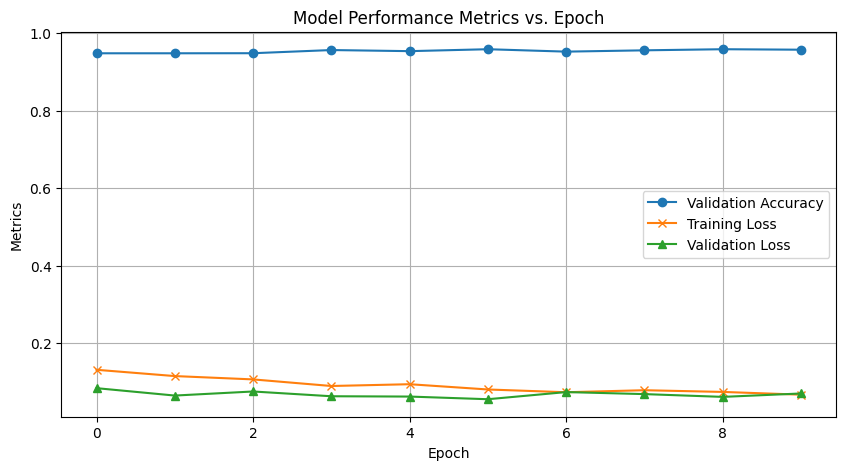

time: 205 ms (started: 2023-12-16 17:33:00 +00:00)


In [52]:
import matplotlib.pyplot as plt

train_loss = [0.13150, 0.115300, 0.106700, 0.089700, 0.094300, 0.080700, 0.07360, 0.07880, 0.074400, 0.067300	]
val_loss =[0.084123,0.065032, 0.075535, 0.063261, 0.062436, 0.055586, 0.074018, 0.068781, 0.061620, 0.070405 ]
acc = [0.947948, 0.947948, 0.948126, 0.956298, 0.953455, 0.958430, 0.952212, 0.955587,0.958430, 0.957186 ]

plt.figure(figsize=(10, 5))

plt.plot(acc, marker='o', label='Validation Accuracy')
plt.plot(train_loss, marker='x', label='Training Loss')
plt.plot(val_loss, marker='^', label='Validation Loss')
plt.legend()

plt.title('Model Performance Metrics vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.grid(True)
plt.show()

In [53]:
# Testing finetuned distil bert
test_dataset = tokenized_datasets["test"]

# Use the trainer to evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)

# Print the evaluation results
print(results)

{'eval_loss': 0.060056172311306, 'eval_accuracy': 0.9639692852923804, 'eval_runtime': 18.7594, 'eval_samples_per_second': 13.007, 'eval_steps_per_second': 13.007, 'epoch': 10.0}
time: 19 s (started: 2023-12-16 17:36:53 +00:00)


## Observing model outputs

In [54]:
from transformers import pipeline

# Load the model from the Hugging Face Hub
model_schema_tagger = pipeline(model="alpcaferoglu/t5-finetuned-dbtag-table-part")


config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


time: 45.1 s (started: 2023-12-16 17:37:12 +00:00)


 ['What', '[STAG]', 'O', 'journals', '[STAG]', 'journal', 'has', '[STAG]', 'O', 'James', '[STAG]', 'author.authorName', 'Landay', '[STAG]', 'author.authorName', 'published', '[STAG]', 'paper', 'in', '[STAG]', 'O', '?', '[STAG]', 'O', '[SEP]']


In [55]:
# example_input = all_train_queries[1]
example_input = all_test_queries[8]
example_input_str = " ".join(example_input)
print('example_input_str: ', example_input_str)

example_true_db_tags = all_test_db_tags[8]
print('example_true_db_tags: ', example_true_db_tags)
predicted_outputs = model_schema_tagger(example_input_str)
print('predicted_output: ', predicted_outputs)

example_input_str:  List James Bond directors [TTAG] O TABLE TABLE TABLE [POS] NN NNP NNP NNS [T] actor copyright cast genre classification company director producer directed_by keyword made_by movie tags tv_series writer written_by
example_true_db_tags:  ['O', 'movie', 'movie', 'director', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'actor', 'copyright', 'cast', 'genre', 'classification', 'company', 'director', 'producer', 'directed_by', 'keyword', 'made_by', 'movie', 'tags', 'tv_series', 'writer', 'written_by']


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


predicted_output:  [{'generated_text': 'O director director director O O O O O O O O O O O O actor copyright'}]
time: 683 ms (started: 2023-12-16 17:37:57 +00:00)


In [63]:
## Example from the all_test_queries[8]
example_input_str = 'List James Bond directors [TTAG] O TABLE TABLE TABLE [POS] NN NNP NNP NNS [T] actor copyright cast genre classification company director producer directed_by keyword made_by movie tags tv_series writer written_by'
example_true_db_tags = ['O', 'movie', 'movie', 'director', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'actor', 'copyright', 'cast', 'genre', 'classification', 'company', 'director', 'producer', 'directed_by', 'keyword', 'made_by', 'movie', 'tags', 'tv_series', 'writer', 'written_by']

print('example_input_str: ', example_input_str)
print('example_true_db_tags: ', example_true_db_tags)
predicted_outputs = model_schema_tagger(example_input_str)
print('predicted_output: ', predicted_outputs)


example_input_str:  List James Bond directors [TTAG] O TABLE TABLE TABLE [POS] NN NNP NNP NNS [T] actor copyright cast genre classification company director producer directed_by keyword made_by movie tags tv_series writer written_by
example_true_db_tags:  ['O', 'movie', 'movie', 'director', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'actor', 'copyright', 'cast', 'genre', 'classification', 'company', 'director', 'producer', 'directed_by', 'keyword', 'made_by', 'movie', 'tags', 'tv_series', 'writer', 'written_by']
predicted_output:  [{'generated_text': 'O director director director O O O O O O O O O O O O actor copyright'}]
time: 542 ms (started: 2023-12-16 17:43:04 +00:00)


In [64]:
## Example from the all_test_queries[8]
example_input_str = "List James Bond movies' directors [TTAG] O TABLE TABLE TABLE TABLE [POS] NN NNP NNP NNS POS NNS [T] actor copyright cast genre classification company director producer directed_by keyword made_by movie tags tv_series writer written_by"
example_true_db_tags = ['O', 'movie', 'movie', 'movie', 'director', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'actor', 'copyright', 'cast', 'genre', 'classification', 'company', 'director', 'producer', 'directed_by', 'keyword', 'made_by', 'movie', 'tags', 'tv_series', 'writer', 'written_by']

print('example_input_str: ', example_input_str)
print('example_true_db_tags: ', example_true_db_tags)
predicted_outputs = model_schema_tagger(example_input_str)
print('predicted_output: ', predicted_outputs)


example_input_str:  List James Bond movies' directors [TTAG] O TABLE TABLE TABLE TABLE [POS] NN NNP NNP NNS POS NNS [T] actor copyright cast genre classification company director producer directed_by keyword made_by movie tags tv_series writer written_by
example_true_db_tags:  ['O', 'movie', 'movie', 'movie', 'director', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'actor', 'copyright', 'cast', 'genre', 'classification', 'company', 'director', 'producer', 'directed_by', 'keyword', 'made_by', 'movie', 'tags', 'tv_series', 'writer', 'written_by']
predicted_output:  [{'generated_text': 'O movie movie cast actor actor O O O O O O O O O O O O O'}]
time: 573 ms (started: 2023-12-16 17:43:05 +00:00)


In [65]:
## Example from the all_test_queries[8]actor
example_input_str = "List directors of James Bond movies [TTAG] O TABLE O TABLE TABLE TABLE [POS] NN NNS IN NNP NNP NNS [T]  copyright cast genre classification company director producer directed_by keyword made_by movie tags tv_series writer written_by"
example_true_db_tags = ['O', 'director', 'O', 'movie', 'movie', 'movie', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'actor', 'copyright', 'cast', 'genre', 'classification', 'company', 'director', 'producer', 'directed_by', 'keyword', 'made_by', 'movie', 'tags', 'tv_series', 'writer', 'written_by']

print('example_input_str: ', example_input_str)
print('example_true_db_tags: ', example_true_db_tags)
predicted_outputs = model_schema_tagger(example_input_str)
print('predicted_output: ', predicted_outputs)


example_input_str:  List directors of James Bond movies [TTAG] O TABLE O TABLE TABLE TABLE [POS] NN NNS IN NNP NNP NNS [T]  copyright cast genre classification company director producer directed_by keyword made_by movie tags tv_series writer written_by
example_true_db_tags:  ['O', 'director', 'O', 'movie', 'movie', 'movie', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'actor', 'copyright', 'cast', 'genre', 'classification', 'company', 'director', 'producer', 'directed_by', 'keyword', 'made_by', 'movie', 'tags', 'tv_series', 'writer', 'written_by']
predicted_output:  [{'generated_text': 'O director O movie movie movie O O O O O O O O O O O O O'}]
time: 532 ms (started: 2023-12-16 17:43:05 +00:00)


In [66]:
# example_input = all_train_queries[1]
example_input = all_test_queries[19]
example_input_str = " ".join(example_input)
print('example_input_str: ', example_input_str)

example_true_db_tags = all_test_db_tags[19]
print('example_true_db_tags: ', example_true_db_tags)
predicted_outputs = model_schema_tagger(example_input_str, min_length= 12, max_length=13)
print('predicted_output: ', predicted_outputs)

example_input_str:  Which movies did Alfred Hitchcock direct ? [TTAG] O TABLE O TABLE TABLE TABLE O [POS] WDT NNS VBD NNP NNP JJ . [T] actor copyright cast genre classification company director producer directed_by keyword made_by movie tags tv_series writer written_by
example_true_db_tags:  ['O', 'movie', 'O', 'director', 'director', 'directed_by', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'actor', 'copyright', 'cast', 'genre', 'classification', 'company', 'director', 'producer', 'directed_by', 'keyword', 'made_by', 'movie', 'tags', 'tv_series', 'writer', 'written_by']
predicted_output:  [{'generated_text': 'O movie O director director directed_by O O O O'}]
time: 393 ms (started: 2023-12-16 17:43:06 +00:00)


In [67]:
print(all_test_queries)
print(all_test_db_tags)

[['find', 'the', 'number', 'of', 'actors', 'from', 'Iran', 'who', 'played', 'in', 'Jim', 'Jarmusch', 'movies', '[TTAG]', 'O', 'O', 'O', 'O', 'TABLE', 'O', 'TABLE', 'O', 'TABLE', 'O', 'TABLE', 'TABLE', 'TABLE', '[POS]', 'VB', 'DT', 'NN', 'IN', 'NNS', 'IN', 'NNP', 'WP', 'VBD', 'IN', 'NNP', 'NNP', 'NNS', '[T]', 'actor', 'copyright', 'cast', 'genre', 'classification', 'company', 'director', 'producer', 'directed_by', 'keyword', 'made_by', 'movie', 'tags', 'tv_series', 'writer', 'written_by'], ['Who', 'is', 'the', 'director', 'of', 'the', 'series', 'House', 'of', 'Cards', 'produced', 'by', 'Netflix', '?', '[TTAG]', 'O', 'O', 'O', 'TABLE', 'O', 'O', 'TABLE', 'TABLE', 'TABLE', 'TABLE', 'TABLE', 'O', 'TABLE', 'O', '[POS]', 'WP', 'VBZ', 'DT', 'NN', 'IN', 'DT', 'NN', 'NNP', 'IN', 'NNP', 'VBN', 'IN', 'NNP', '.', '[T]', 'actor', 'copyright', 'cast', 'genre', 'classification', 'company', 'director', 'producer', 'directed_by', 'keyword', 'made_by', 'movie', 'tags', 'tv_series', 'writer', 'written_by

In [68]:
total_pred = 0
correct_pred = 0
for idx, test_query in enumerate(all_test_queries):
  test_query_concat = " ".join(test_query)
  test_query_true_db_tags = all_test_db_tags[idx]
  test_query_type_tags = all_test_type_tags[idx]
  min_len = len(test_query_type_tags)
  max_len = min_len + 1
  predicted_db_tags = model_schema_tagger(test_query_concat, min_length=min_len, max_length=max_len)

  predicted_db_tags = predicted_db_tags[0]["generated_text"].split(" ")

  for i, pred_db_tag in enumerate(predicted_db_tags):
    if(test_query_true_db_tags[i].lower() == pred_db_tag.lower()):
      correct_pred += 1

  total_pred += len(predicted_db_tags)

time: 1min 19s (started: 2023-12-16 17:43:06 +00:00)


In [69]:
print(f"test accuracy: {correct_pred / total_pred}")

test accuracy: 0.9170912459471978
time: 463 µs (started: 2023-12-16 17:44:25 +00:00)


time: 6.34 ms (started: 2023-12-16 17:44:25 +00:00)
